<a href="https://colab.research.google.com/github/gladysadyaz/VAR/blob/main/7LINEAR_Hybrid_LSTM__Wisman.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
import random
import warnings
import itertools
import statsmodels.api as sm
import tensorflow.keras as keras
import seaborn as sns
import tensorflow as tf
import gc

from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from keras.callbacks import EarlyStopping
from numpy import array

%matplotlib inline
plt.style.use('fivethirtyeight')
warnings.filterwarnings("ignore")

Mounted at /content/drive


In [2]:
pd.options.display.float_format = '{:.2f}'.format

# MODELING

# B. LONG SHORT TERM MEMORY

## Splitting & Scaling

In [2]:
file_path_actual = "/content/drive/My Drive/Colab Notebooks/wisman bali-kurs (1).xlsx"
df_actual = pd.read_excel(file_path_actual, sheet_name='Sheet1')
df_actual['Date'] = pd.to_datetime(df_actual['Date'], format='%d/%m/%Y')
df_actual.set_index('Date', inplace=True)
print(df_actual.head())

             Kurs  Wisman Bali  Hari Raya
Date                                     
2023-01-01  15592        10626          1
2023-01-02  15572        12338          1
2023-01-03  15590        12122          1
2023-01-04  15615        11957          1
2023-01-05  15610        13463          1


In [3]:
file_path = "/content/drive/My Drive/Colab Notebooks/varx_residuals.xlsx"
df = pd.read_excel(file_path, sheet_name='FIXVAR')
df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%Y')
df.set_index('Date', inplace=True)
print(df.head())

             Kurs  Wisman Bali
Date                          
2023-01-02 -19.95         1700
2023-01-03   2.17         2052
2023-01-04  22.77         2008
2023-01-05  18.88         3759
2023-01-06  43.49         3592


In [4]:
steps_slicing = 90
df_final = df_actual[:-steps_slicing]
df_update = df_actual[-steps_slicing:]

In [5]:
# Select only the 'Wisman Bali' column for input and output
df_residual = df['Wisman Bali']
data2 = df_residual.copy()
data2

,Wisman Bali
Date,
2023-01-02,1700
2023-01-03,2052
2023-01-04,2008
2023-01-05,3759
2023-01-06,3592
...,...
2025-01-16,-2399
2025-01-17,-1242
2025-01-18,-1792


In [6]:
scaler2 = MinMaxScaler()
scaled_data2 = scaler2.fit_transform(data2.values.reshape(-1, 1))

In [7]:
# Prepare the dataset for LSTM
def create_dataset(data, time_step=1):
    dataX, dataY = [], []
    for i in range(len(data)-time_step):
        a = data[i:(i+time_step), 0]  # Use only the first column
        dataX.append(a)
        dataY.append(data[i + time_step, 0])  # Use only the first column
    return np.array(dataX), np.array(dataY)

In [8]:
# Set the time step
time_step = 7

# Create the dataset for LSTM
X2, y2 = create_dataset(scaled_data2, time_step)

# Reshape X2 to be [samples, time steps, features] which is required for LSTM
X2 = X2.reshape(X2.shape[0], X2.shape[1], 1)

In [9]:
test_size2 = 90
train_size2 = len(X2) - test_size2
X2_train, X2_test = X2[:train_size2], X2[train_size2:]
y2_train, y2_test = y2[:train_size2], y2[train_size2:]

## Hypertuning Parameters

In [10]:
# Function to create model for LSTM
def create_model_lstm2(units1, units2, dropout_rate, learning_rate, init_scheme):
    seed_value = 54
    random.seed(seed_value)
    np.random.seed(seed_value)
    tf.random.set_seed(seed_value)
    model = Sequential()
    model.add(LSTM(units=units1, return_sequences=True, input_shape=(time_step, 1), kernel_initializer=init_scheme))
    model.add(Dropout(rate=dropout_rate))
    model.add(LSTM(units=units2, kernel_initializer=init_scheme))
    model.add(Dropout(rate=dropout_rate))
    model.add(Dense(1, activation='linear', kernel_initializer=init_scheme))
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mean_squared_error')
    return model

In [11]:
# Define the hyperparameter grid for LSTM
param_grid_lstm2 = {
    'units1': [50,100],
    'units2': [50,100],
    'dropout_rate': [0.2, 0.3],
    'learning_rate': [0.01,0.001],
    'batch_size': [16],
    'epochs': [100],
    'init_scheme': ['he_uniform', 'glorot_uniform']
}

In [12]:
from itertools import product
# Convert param_grid to a list of dictionaries
param_list_lstm2 = list(product(param_grid_lstm2['units1'],
                                param_grid_lstm2['units2'],
                                param_grid_lstm2['dropout_rate'],
                                param_grid_lstm2['learning_rate'],
                                param_grid_lstm2['batch_size'],
                                param_grid_lstm2['epochs'],
                                param_grid_lstm2['init_scheme'],))

In [13]:
from sklearn.metrics import mean_absolute_percentage_error
from tensorflow.keras.callbacks import EarlyStopping
from tqdm import tqdm
import numpy as np

# Inisialisasi variabel untuk tracking model terbaik
best_score_lstm2 = float('inf')
best_params_lstm2 = None
best_model_lstm2 = None

# Ukuran train-test dan shifting antar window
train_sz = 90
test_sz = 30
shift = 89

# Loop untuk grid search dengan parameter dari param_list_lstm2
for params in tqdm(param_list_lstm2):
    val_mape_scores = []
    units1, units2, dropout_rate, learning_rate, batch_size, epochs, init_scheme = params

    for i in range(8):
        idx_train = train_sz + shift * i
        idx_test = train_sz + test_sz + shift * i

        # Split data
        X2_train, X2_test = X2[:idx_train], X2[idx_train:idx_test]
        y2_train, y2_test = y2[:idx_train], y2[idx_train:idx_test]

        # Buat model LSTM2 dengan parameter saat ini
        model_lstm2 = create_model_lstm2(units1, units2, dropout_rate, learning_rate, init_scheme)

        # Callback early stopping
        early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

        # Training
        model_lstm2.fit(
            X2_train, y2_train,
            batch_size=batch_size,
            epochs=epochs,
            validation_data=(X2_test, y2_test),
            callbacks=[early_stopping],
            verbose=0
        )

        # Prediksi dan inverse transform
        y2_test_pred = model_lstm2.predict(X2_test)
        y2_test_pred_denorm = scaler2.inverse_transform(y2_test_pred).flatten()
        y2_test_denorm = scaler2.inverse_transform(y2_test.reshape(-1, 1)).flatten()

        # Hitung MAPE
        mape_score = mean_absolute_percentage_error(y2_test_denorm, y2_test_pred_denorm)
        val_mape_scores.append(mape_score)

        # Opsional: lihat MAPE per window
        #print(f"MAPE window {i+1}: {mape_score:.4f}")

    # Hitung rata-rata MAPE dari 8 window
    mape_avg = np.mean(val_mape_scores)

    # Simpan jika ini model terbaik sejauh ini
    if mape_avg < best_score_lstm2:
        best_score_lstm2 = mape_avg
        best_params_lstm2 = {
            'units1': units1,
            'units2': units2,
            'dropout_rate': dropout_rate,
            'learning_rate': learning_rate,
            'batch_size': batch_size,
            'epochs': epochs,
            'init_scheme': init_scheme
        }
        best_model_lstm2 = model_lstm2

# Print hasil akhir
print(f"Best LSTM2 average MAPE: {best_score_lstm2:.4f}")
print(f"Best parameters: {best_params_lstm2}")

  0%|          | 0/32 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 394ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step


  3%|▎         | 1/32 [01:04<33:32, 64.91s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 452ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 322ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 464ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step


  6%|▋         | 2/32 [02:01<30:04, 60.16s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 448ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 319ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 440ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step


  9%|▉         | 3/32 [03:09<30:39, 63.44s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 406ms/step


 12%|█▎        | 4/32 [04:08<28:50, 61.82s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 431ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 432ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step


 16%|█▌        | 5/32 [05:05<27:07, 60.27s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 433ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step


 19%|█▉        | 6/32 [06:06<26:09, 60.37s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 322ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 359ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 351ms/step


 22%|██▏       | 7/32 [07:08<25:18, 60.74s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 485ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 324ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 417ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 401ms/step


 25%|██▌       | 8/32 [08:13<24:54, 62.29s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 432ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 434ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 431ms/step


 28%|██▊       | 9/32 [09:19<24:15, 63.28s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 425ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step


 31%|███▏      | 10/32 [10:22<23:16, 63.45s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 471ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 319ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 449ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 348ms/step


 34%|███▍      | 11/32 [11:29<22:33, 64.45s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 451ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 463ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 410ms/step


 38%|███▊      | 12/32 [12:30<21:08, 63.42s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 319ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 449ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 323ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 463ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step


 41%|████      | 13/32 [13:32<19:56, 63.00s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 466ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 319ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 326ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 505ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step


 44%|████▍     | 14/32 [14:41<19:23, 64.63s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 477ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 420ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step


 47%|████▋     | 15/32 [15:37<17:38, 62.24s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 506ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 477ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step


 50%|█████     | 16/32 [16:50<17:28, 65.50s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 431ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 451ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step


 53%|█████▎    | 17/32 [17:49<15:51, 63.42s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 424ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 319ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step


 56%|█████▋    | 18/32 [18:54<14:53, 63.83s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 324ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 352ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step


 59%|█████▉    | 19/32 [20:02<14:06, 65.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 322ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 413ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 434ms/step


 62%|██████▎   | 20/32 [21:05<12:55, 64.65s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 440ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 403ms/step


 66%|██████▌   | 21/32 [22:10<11:49, 64.52s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 453ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 319ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step


 69%|██████▉   | 22/32 [23:15<10:48, 64.81s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 469ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 326ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 335ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step


 72%|███████▏  | 23/32 [24:28<10:04, 67.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 441ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step


 75%|███████▌  | 24/32 [25:36<09:00, 67.56s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 414ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 324ms/step


 78%|███████▊  | 25/32 [26:37<07:39, 65.65s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 426ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step


 81%|████████▏ | 26/32 [27:38<06:25, 64.20s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 326ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 340ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 340ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step


 84%|████████▍ | 27/32 [28:53<05:36, 67.36s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 329ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step


 88%|████████▊ | 28/32 [29:50<04:17, 64.31s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 374ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 329ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 446ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step


 91%|█████████ | 29/32 [30:56<03:13, 64.65s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step


 94%|█████████▍| 30/32 [32:05<02:11, 65.95s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step


 97%|█████████▋| 31/32 [33:05<01:04, 64.35s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 363ms/step


100%|██████████| 32/32 [34:11<00:00, 64.11s/it]

Best LSTM2 average MAPE: 0.5798
Best parameters: {'units1': 50, 'units2': 100, 'dropout_rate': 0.3, 'learning_rate': 0.01, 'batch_size': 16, 'epochs': 100, 'init_scheme': 'glorot_uniform'}


## Model

In [14]:
best_params_lstm2

{'units1': 50,
 'units2': 100,
 'dropout_rate': 0.3,
 'learning_rate': 0.01,
 'batch_size': 16,
 'epochs': 100,
 'init_scheme': 'glorot_uniform'}

In [15]:
# Re-split data untuk pelatihan akhir model (bukan CV)
test_size2 = 90
train_size2 = len(X2) - test_size2

X2_train = X2[:train_size2]
X2_test = X2[train_size2:]
y2_train = y2[:train_size2]
y2_test = y2[train_size2:]

# Ambil parameter terbaik dari hasil grid search
manual_units1_lstm2 = best_params_lstm2['units1']
manual_units2_lstm2 = best_params_lstm2['units2']
manual_dropout_rate_lstm2 = best_params_lstm2['dropout_rate']
manual_learning_rate_lstm2 = best_params_lstm2['learning_rate']
manual_batch_size_lstm2 = best_params_lstm2['batch_size']
manual_epochs_lstm2 = best_params_lstm2['epochs']
manual_init_scheme_lstm2 = best_params_lstm2['init_scheme']

# Buat model dengan parameter terbaik
model_manual_lstm2 = create_model_lstm2(manual_units1_lstm2,
                                        manual_units2_lstm2,
                                        manual_dropout_rate_lstm2,
                                        manual_learning_rate_lstm2,
                                        manual_init_scheme_lstm2)

# Early stopping callbacks
early_stopping = EarlyStopping(monitor='val_loss',
                               patience=50,
                               restore_best_weights=True)

# Latih model dengan parameter terbaik
history_manual_lstm2 = model_manual_lstm2.fit(X2_train,
                                              y2_train,
                                              batch_size=manual_batch_size_lstm2,
                                              epochs=manual_epochs_lstm2,
                                              validation_data=(X2_test, y2_test),
                                              callbacks=[early_stopping],
                                              verbose=1)

Epoch 1/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 6s 38ms/step - loss: 0.2676 - val_loss: 0.0123
Epoch 2/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0141 - val_loss: 0.0069
Epoch 3/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0089 - val_loss: 0.0035
Epoch 4/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0092 - val_loss: 0.0044
Epoch 5/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0090 - val_loss: 0.0034
Epoch 6/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0090 - val_loss: 0.0060
Epoch 7/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0065 - val_loss: 0.0082
Epoch 8/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0058 - val_loss: 0.0038
Epoch 9/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0081 - val_loss: 0.0089
Epoch 10/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0059 - val_loss: 0.0046
Epoch 11/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0052 - val_loss: 0.0064
Epoch 12/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

In [16]:
# Summary model
model_manual_lstm2.summary()

Model: "sequential_256"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_512 (LSTM)                 │ (None, 7, 50)          │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_512 (Dropout)           │ (None, 7, 50)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_513 (LSTM)                 │ (None, 100)            │        60,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_513 (Dropout)           │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_256 (Dense)               │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 212,705 (830.88 KB)

 Trainable params: 70,901 (276.96 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 141,804 (553.93 KB)

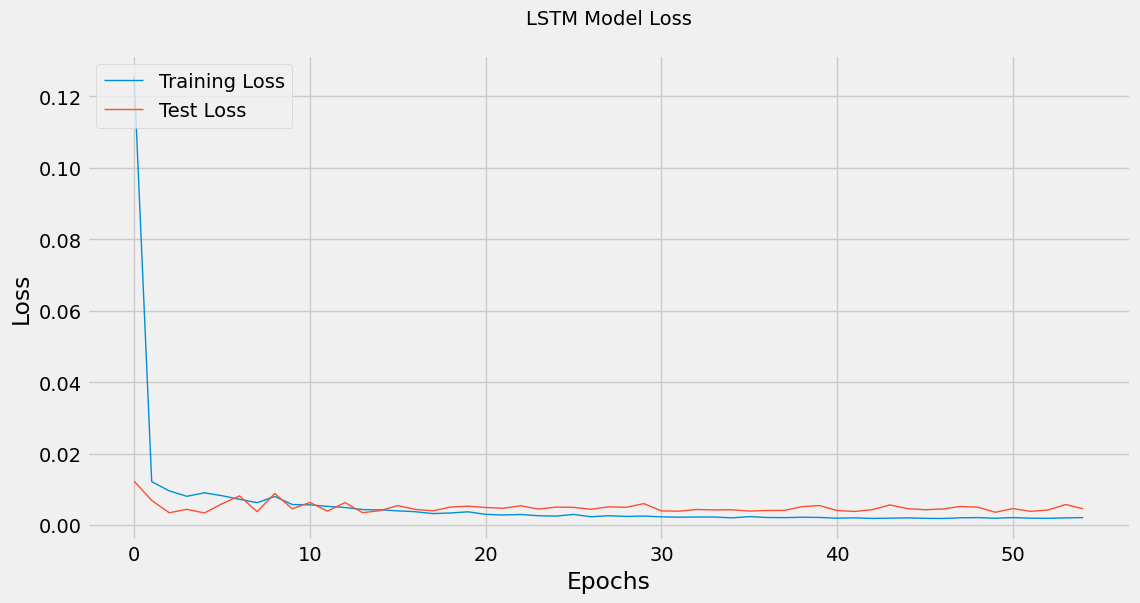

In [17]:
# Plot Data
plt.figure(figsize=(12, 6))
plt.plot(history_manual_lstm2.history['loss'], label='Training Loss', linewidth=1)
plt.plot(history_manual_lstm2.history['val_loss'], label='Test Loss', linewidth=1)
plt.title('LSTM Model Loss\n', fontsize=14)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('LSTM Model Loss\n', fontsize=14)
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

In [18]:
# Predict on the training data for LSTM
train_predict_lstm2 = model_manual_lstm2.predict(X2_train)
test_predict_lstm2 = model_manual_lstm2.predict(X2_test)

21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


In [19]:
# Inverse transform the predictions for LSTM
train_predict_lstm2 = scaler2.inverse_transform(train_predict_lstm2)
test_predict_lstm2 = scaler2.inverse_transform(test_predict_lstm2)
y2_train = scaler2.inverse_transform(y2_train.reshape(-1, 1))
y2_test = scaler2.inverse_transform(y2_test.reshape(-1, 1))

## Evaluation & Visualization

In [20]:
# Calculate MAPE for LSTM
train_mape_kurs_lstm2 = mean_absolute_percentage_error(y2_train, train_predict_lstm2)
test_mape_kurs_lstm2 = mean_absolute_percentage_error(y2_test, test_predict_lstm2)

print(f'Training MAPE (Wisman Bali) LSTM: {train_mape_kurs_lstm2:.4f}')
print(f'Testing MAPE (Wisman Bali) LSTM: {test_mape_kurs_lstm2:.4f}')


Training MAPE (Wisman Bali) LSTM: 0.8989
Testing MAPE (Wisman Bali) LSTM: 1.8661


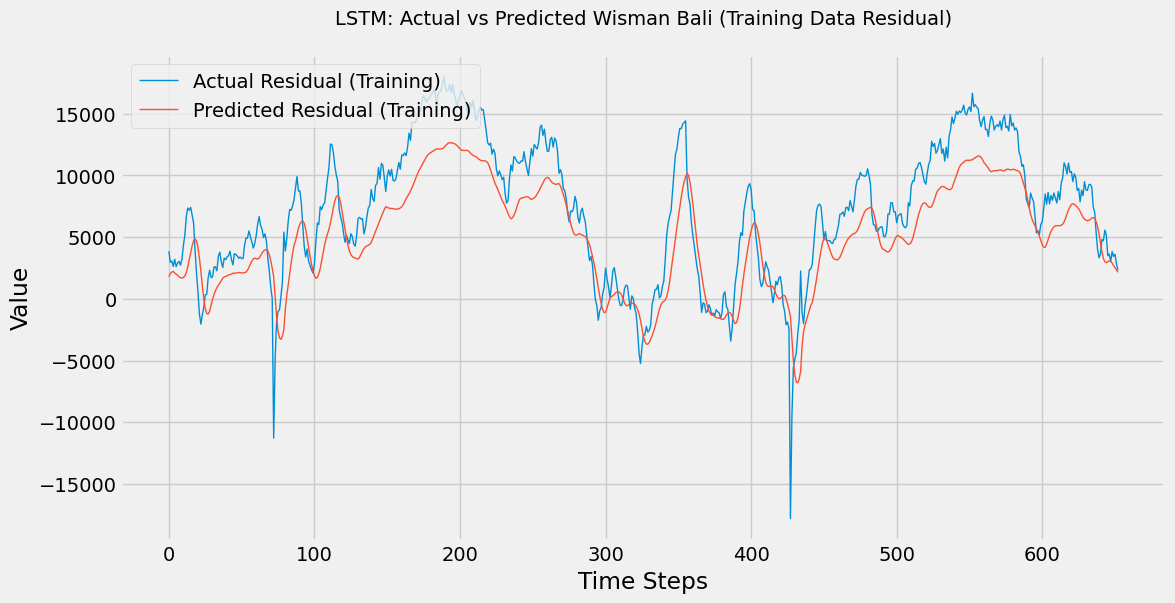

In [21]:
# Plot Data
plt.figure(figsize=(12, 6))
plt.plot(y2_train, label='Actual Residual (Training)', linewidth=1)
plt.plot(train_predict_lstm2, label='Predicted Residual (Training)', linewidth=1)
plt.xlabel('Time Steps')
plt.ylabel('Value')
plt.title('LSTM: Actual vs Predicted Wisman Bali (Training Data Residual)\n', fontsize=14)
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

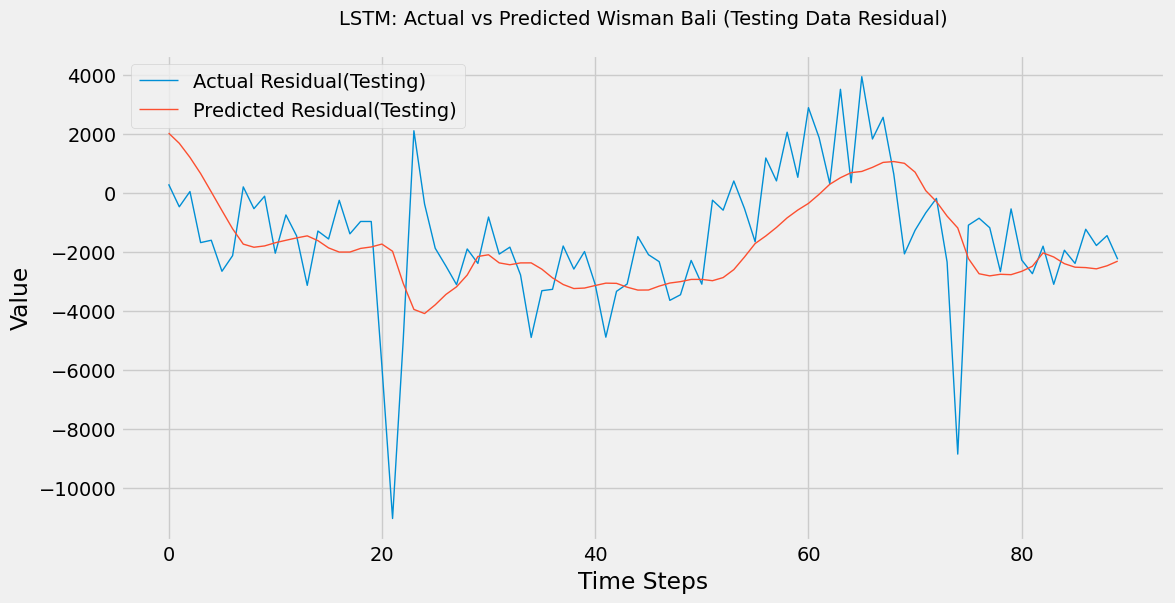

In [22]:
# Plot Data
plt.figure(figsize=(12, 6))
plt.plot(y2_test, label='Actual Residual(Testing)', linewidth=1)
plt.plot(test_predict_lstm2, label='Predicted Residual(Testing)', linewidth=1)
plt.xlabel('Time Steps')
plt.ylabel('Value')
plt.title('LSTM: Actual vs Predicted Wisman Bali (Testing Data Residual)\n', fontsize=14)
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

In [23]:
import pandas as pd

# Biar aman, kita flatten dulu kalau masih 2D
actual = y2_test.flatten()
predicted = test_predict_lstm2.flatten()

start_date = pd.to_datetime('2024-10-23')
dates = pd.date_range(start=start_date, periods=90, freq='D')

df_result = pd.DataFrame({
    'Date': dates,
    'Actual Residual': actual,
    'Predicted Residual': predicted
})
df_result.set_index('Date', inplace=True)
print(df_result)

            Actual Residual  Predicted Residual
Date                                           
2024-10-23            283.0         2017.799561
2024-10-24           -480.0         1671.009155
2024-10-25             36.0         1194.629028
2024-10-26          -1694.0          645.781128
2024-10-27          -1614.0           23.544661
...                     ...                 ...
2025-01-16          -2399.0        -2527.047607
2025-01-17          -1242.0        -2540.512451
2025-01-18          -1792.0        -2583.220215
2025-01-19          -1457.0        -2479.414307
2025-01-20          -2259.0        -2321.409668

[90 rows x 2 columns]


In [24]:
df_nonlinear_test = (df_result[['Predicted Residual']])
df_nonlinear_test

,Predicted Residual
Date,
2024-10-23,2017.799561
2024-10-24,1671.009155
2024-10-25,1194.629028
2024-10-26,645.781128
2024-10-27,23.544661
...,...
2025-01-16,-2527.047607
2025-01-17,-2540.512451
2025-01-18,-2583.220215


## Forecasting



In [25]:
# Forecasting for the next 14 steps
predictions_lstm2 = []
input_data_lstm2 = scaled_data2[-time_step:].reshape(1, time_step, 1)

for _ in range(14):
    pred = model_manual_lstm2.predict(input_data_lstm2)
    predictions_lstm2.append(pred[0])
    input_data_lstm2 = np.append(input_data_lstm2[:, 1:, :], [[pred[0]]], axis=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


In [26]:
# Inverse transform the predictions to original scale
predictions_lstm2 = scaler2.inverse_transform(predictions_lstm2)

# Save predictions to DataFrame
df_future_predictions_lstm2 = pd.DataFrame(predictions_lstm2, columns=['Predicted Residual Wisman Bali'])

# Assuming df_update is the dataframe where you want to align future predictions, here aligning index with the valid_data's last 7 steps.
dates = pd.date_range(start="2025-01-21", periods=14, freq='D')
df_future_predictions_lstm2.index = dates

# Display the future predictions DataFrame
df_future_predictions_lstm2

,Predicted Residual Wisman Bali
2025-01-21,-2301.415568
2025-01-22,-2245.820243
2025-01-23,-2306.663470
2025-01-24,-2350.451817
2025-01-25,-2474.178115
2025-01-26,-2555.101848
2025-01-27,-2658.293157
2025-01-28,-2709.676505
2025-01-29,-2766.885996
2025-01-30,-2832.896043


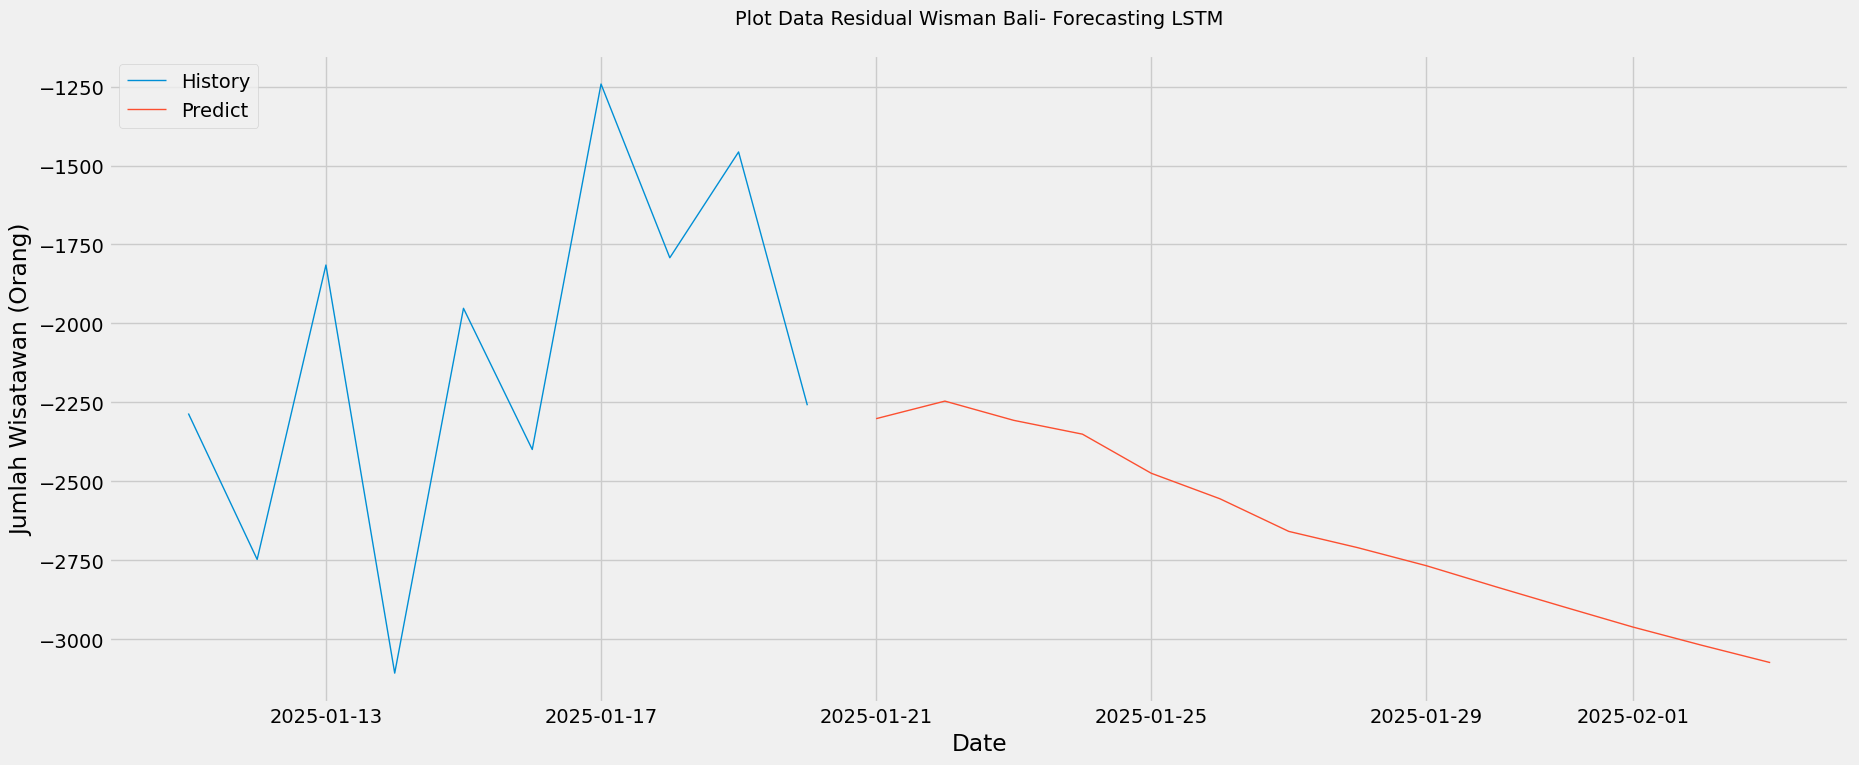

In [27]:
# Plot Data
plt.figure(figsize=(20, 8))
plt.plot(df.iloc[-10:]['Wisman Bali'], linewidth=1, label='History')
plt.plot(df_future_predictions_lstm2['Predicted Residual Wisman Bali'], linewidth=1, label='Predict')
plt.xlabel('Date')
plt.ylabel('Jumlah Wisatawan (Orang)')
plt.title('Plot Data Residual Wisman Bali- Forecasting LSTM\n', fontsize=14)
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

# C. HYBRID VAR LSTM

## Model

In [28]:
file_path_forecast = "/content/drive/My Drive/Colab Notebooks/varx_forecast.xlsx"
df_forecast = pd.read_excel(file_path_forecast, sheet_name='FIXVAR')
df_forecast['Date'] = pd.to_datetime(df_forecast['Date'], format='%d/%m/%Y')
df_forecast.set_index('Date', inplace=True)
print(df_forecast.head())

                Kurs  Wisman Bali
Date                             
2024-10-23  15563.19        19031
2024-10-24  15556.90        19251
2024-10-25  15558.64        20218
2024-10-26  15557.91        19982
2024-10-27  15553.73        20022


In [29]:
df_linear = df_forecast[['Wisman Bali']]
df_linear90 = df_linear[:-30]
df_linear90

,Wisman Bali
Date,
2024-10-23,19031
2024-10-24,19251
2024-10-25,20218
2024-10-26,19982
2024-10-27,20022
...,...
2025-01-16,20420
2025-01-17,20432
2025-01-18,20444


In [30]:
df_hybrid = pd.DataFrame({
    'Hybrid Wisman Bali': df_linear90['Wisman Bali'] + df_nonlinear_test['Predicted Residual'],
})
df_hybrid

,Hybrid Wisman Bali
Date,
2024-10-23,21048.799561
2024-10-24,20922.009155
2024-10-25,21412.629028
2024-10-26,20627.781128
2024-10-27,20045.544661
...,...
2025-01-16,17892.952393
2025-01-17,17891.487549
2025-01-18,17860.779785


In [31]:
df_hybrid_final = pd.merge(df_update['Wisman Bali'], df_hybrid, left_index=True, right_index=True)
print(df_hybrid_final.shape)
df_hybrid_final

(90, 2)


,Wisman Bali,Hybrid Wisman Bali
Date,,
2024-10-23,19314,21048.799561
2024-10-24,18771,20922.009155
2024-10-25,20254,21412.629028
2024-10-26,18288,20627.781128
2024-10-27,18408,20045.544661
...,...,...
2025-01-16,18021,17892.952393
2025-01-17,19190,17891.487549
2025-01-18,18652,17860.779785


## Evaluation & Visualization

In [32]:
# Define true and predicted 'Close' values
y_true = df_hybrid_final['Wisman Bali']
y_pred = df_hybrid_final['Hybrid Wisman Bali']

In [33]:
mape = mean_absolute_percentage_error(y_true, y_pred) * 100  # dikali 100 agar jadi persentase
print(f"Mean Absolute Percentage Error (MAPE) for Hybrid Wisman Bali: {mape:.2f}%")

Mean Absolute Percentage Error (MAPE) for Hybrid Wisman Bali: 8.66%


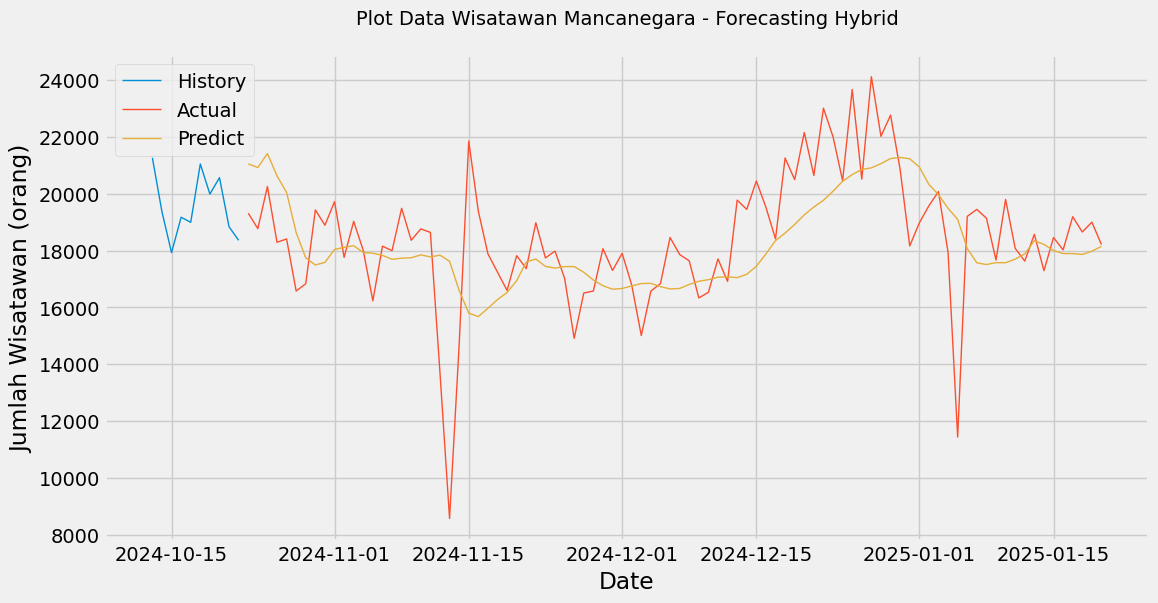

In [34]:
# Plot Data
# Plot Data
plt.figure(figsize=(12, 6))
plt.plot(df_final.iloc[-10:]['Wisman Bali'], linewidth=1, label='History')
plt.plot(df_hybrid_final['Wisman Bali'], linewidth=1, label='Actual')
plt.plot(df_hybrid_final['Hybrid Wisman Bali'], linewidth=1, label='Predict')
plt.xlabel('Date')
plt.ylabel('Jumlah Wisatawan (orang)')
plt.title('Plot Data Wisatawan Mancanegara - Forecasting Hybrid\n', fontsize=14)
plt.legend(loc='upper left')
plt.grid(True)
plt.show()


# Forecast 14 Hari

In [35]:
# Forecasting for the next 30 steps
predictions_lstm2 = []
input_data_lstm2 = scaled_data2[-time_step:].reshape(1, time_step, 1)

for _ in range(14):
    pred = model_manual_lstm2.predict(input_data_lstm2)
    predictions_lstm2.append(pred[0])
    input_data_lstm2 = np.append(input_data_lstm2[:, 1:, :], [[pred[0]]], axis=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


In [36]:
dates = pd.date_range(start="2025-01-21", periods=14, freq='D')

In [37]:
# Inverse transform the predictions to original scale
predictions_lstm2 = scaler2.inverse_transform(predictions_lstm2)

# Save predictions to DataFrame
df_future_predictions_lstm2 = pd.DataFrame(predictions_lstm2, columns=['Predicted Residual Wisman Bali'])

df_future_predictions_lstm2.index = dates

# Display the future predictions DataFrame
df_future_predictions_lstm2

,Predicted Residual Wisman Bali
2025-01-21,-2301.415568
2025-01-22,-2245.820243
2025-01-23,-2306.663470
2025-01-24,-2350.451817
2025-01-25,-2474.178115
2025-01-26,-2555.101848
2025-01-27,-2658.293157
2025-01-28,-2709.676505
2025-01-29,-2766.885996
2025-01-30,-2832.896043


In [38]:
df_linear = df_forecast[['Wisman Bali']]
df_linear30 = df_linear[-30:]
df_linear14 = df_linear30[:-16]
df_linear14

,Wisman Bali
Date,
2025-01-21,20478
2025-01-22,20490
2025-01-23,20501
2025-01-24,20513
2025-01-25,20524
2025-01-26,20536
2025-01-27,20547
2025-01-28,20559
2025-01-29,20570


In [39]:
df_nonlinear = df_future_predictions_lstm2.copy()
df_nonlinear

,Predicted Residual Wisman Bali
2025-01-21,-2301.415568
2025-01-22,-2245.820243
2025-01-23,-2306.663470
2025-01-24,-2350.451817
2025-01-25,-2474.178115
2025-01-26,-2555.101848
2025-01-27,-2658.293157
2025-01-28,-2709.676505
2025-01-29,-2766.885996
2025-01-30,-2832.896043


In [40]:
df_hybrid = pd.DataFrame({
    'Hybrid Wisman Bali': df_linear14['Wisman Bali'] + df_nonlinear['Predicted Residual Wisman Bali'],
})
df_hybrid

,Hybrid Wisman Bali
Date,
2025-01-21,18176.584432
2025-01-22,18244.179757
2025-01-23,18194.336530
2025-01-24,18162.548183
2025-01-25,18049.821885
2025-01-26,17980.898152
2025-01-27,17888.706843
2025-01-28,17849.323495
2025-01-29,17803.114004


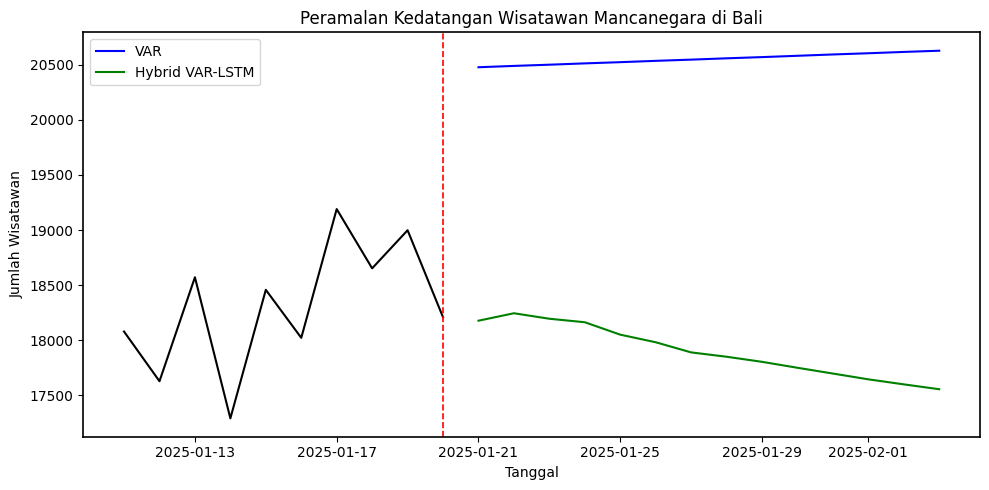

In [41]:
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt

plt.style.use('default')


fig, ax = plt.subplots(figsize=(10,5))  # buat figure dan axes secara eksplisit

# plot di axes yang sudah dibuat
ax.plot(df_update.index[-10:], df_update['Wisman Bali'][-10:],  color='black', linewidth=1.5)
ax.plot(df_linear14.index, df_linear14, label='VAR', color='blue', linewidth=1.5)
ax.plot(df_hybrid.index, df_hybrid, label='Hybrid VAR-LSTM', color='green', linewidth=1.5)

cutoff_date = df_update.index[-1]
ax.axvline(x=cutoff_date, color='red', linestyle='--', linewidth=1.2)

# hilangkan grid dalam (kotak bantu)
ax.grid(False)

# pastikan semua spines aktif dan terlihat
for spine in ['top', 'bottom', 'left', 'right']:
    ax.spines[spine].set_visible(True)
    ax.spines[spine].set_linewidth(1.2)

# label dan judul
ax.set_title('Peramalan Kedatangan Wisatawan Mancanegara di Bali')
ax.set_xlabel('Tanggal')
ax.set_ylabel('Jumlah Wisatawan')
ax.legend()

plt.tight_layout()
plt.show()
